In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/alxmamaev/flowers-recognition")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: afreenhossain
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition


100%|██████████| 225M/225M [00:03<00:00, 71.6MB/s]


In [ ]:
data_dir = '/content/flowers-recognition/flowers'

In [ ]:
import os

In [ ]:
os.listdir(data_dir)

['tulip', 'daisy', 'rose', 'dandelion', 'sunflower']

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
dataset

Dataset ImageFolder
    Number of datapoints: 4317
    Root location: /content/flowers-recognition/flowers

In [ ]:
len(dataset)

4317

In [ ]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263>, 0)

In [ ]:
img, label = dataset[0]

Text(0.5, 1.0, 'Belongs to class 0, which is daisy')

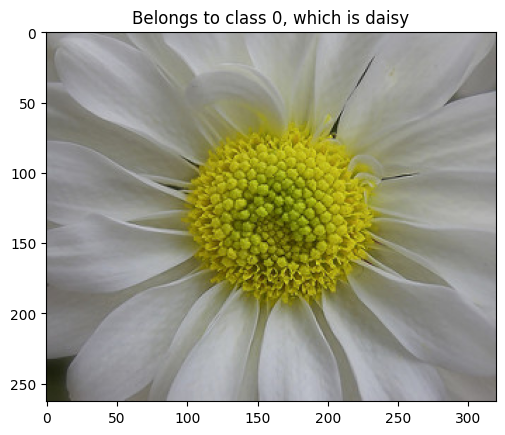

In [ ]:
plt.imshow(img)
plt.title(f"Belongs to class {label}, which is {dataset.classes[label]}")

In [ ]:
import torchvision.transforms as tt

In [ ]:
dataset = ImageFolder(data_dir, tt.Compose([
    tt.Resize(224),
    tt.RandomCrop(224),
    tt.ToTensor()
]))

In [ ]:
img, label = dataset[0]

Text(0.5, 1.0, 'Belongs to class 0, which is daisy')

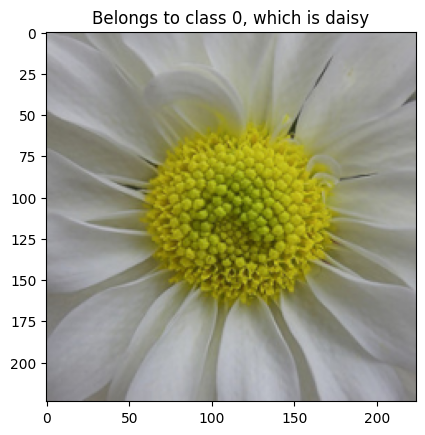

In [ ]:
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Belongs to class {label}, which is {dataset.classes[label]}")

In [ ]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = int(len(dataset) - val_size)

train_size, val_size

(3886, 431)

In [ ]:
from torch.utils.data import random_split

In [ ]:
train_ds, valid_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(valid_ds)

(3886, 431)

In [ ]:
from torch.utils.data.dataloader import DataLoader

import warnings
warnings.filterwarnings("ignore")

In [ ]:
batch_size = 16

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(valid_ds, batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([]);
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

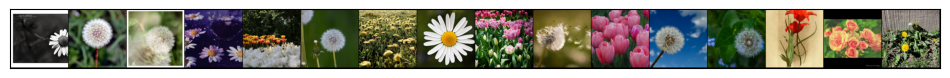

In [ ]:
show_batch(train_dl)

In [ ]:
for cls in os.listdir(data_dir):
  print(cls, ":", len(os.listdir(data_dir + "/" + cls)))

tulip : 984
daisy : 764
rose : 784
dandelion : 1052
sunflower : 733


In [ ]:
import torch

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device("cpu")


def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """Yield a batch of data after moving it to device"""
    for b in self.dl:
        yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
img, label = dataset[0]

In [ ]:
img.shape

torch.Size([3, 224, 224])

In [ ]:
img.device

device(type='cpu')

In [ ]:
img = to_device(img, device)
img.device

device(type='cuda', index=0)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(train_dl, device)

In [ ]:
train_dl.device, valid_dl.device

(device(type='cuda'), device(type='cuda'))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    "calculate loss for a batch of training data"
    images, labels = batch
    out = self(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss

  def validation_step(self, batch):
    "calculate loss & accuracy for a batch of validation data"
    images, labels = batch
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """Evaluates the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32

        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
for batch in train_dl:
  images, labels = batch
  print(images)
  print(labels)
  print(len(images))
  print(len(labels))
  break

tensor([[[[0.9765, 0.8431, 0.6941,  ..., 0.9647, 0.9647, 0.9647],
          [0.9804, 0.8667, 0.7216,  ..., 0.9647, 0.9647, 0.9647],
          [0.9843, 0.8902, 0.7490,  ..., 0.9647, 0.9647, 0.9647],
          ...,
          [0.9608, 0.8314, 0.6902,  ..., 0.8196, 0.8902, 0.9569],
          [0.9725, 0.8235, 0.6745,  ..., 0.8118, 0.8863, 0.9569],
          [0.9882, 0.8275, 0.6745,  ..., 0.8078, 0.8824, 0.9529]],

         [[0.8275, 0.6941, 0.5451,  ..., 0.8118, 0.8118, 0.8118],
          [0.8314, 0.7176, 0.5725,  ..., 0.8118, 0.8118, 0.8118],
          [0.8353, 0.7412, 0.6000,  ..., 0.8118, 0.8118, 0.8118],
          ...,
          [0.8118, 0.6824, 0.5412,  ..., 0.6706, 0.7412, 0.8078],
          [0.8235, 0.6745, 0.5255,  ..., 0.6627, 0.7373, 0.8078],
          [0.8392, 0.6784, 0.5255,  ..., 0.6588, 0.7333, 0.8039]],

         [[0.6863, 0.5529, 0.4039,  ..., 0.6824, 0.6824, 0.6824],
          [0.6902, 0.5765, 0.4314,  ..., 0.6824, 0.6824, 0.6824],
          [0.6941, 0.6000, 0.4588,  ..., 0

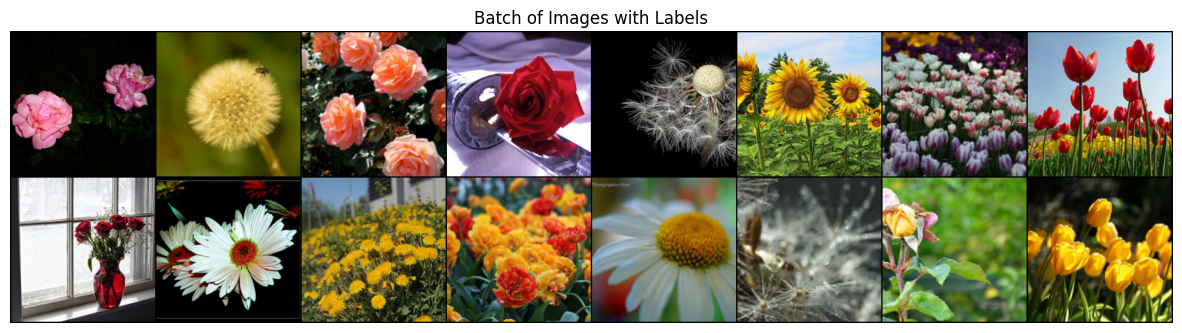

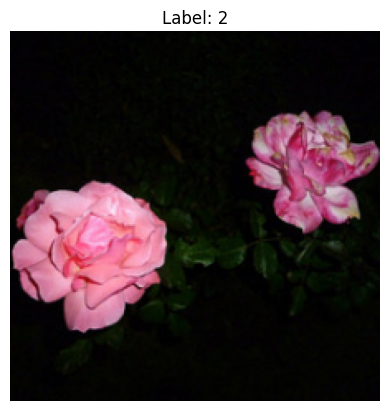

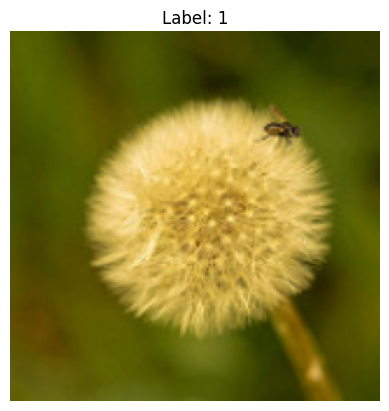

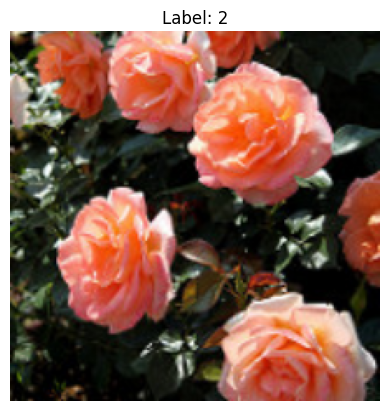

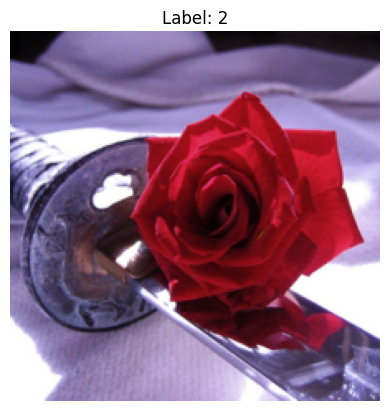

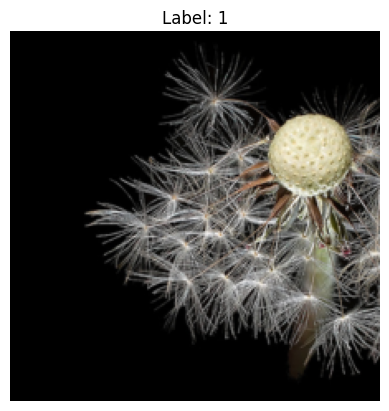

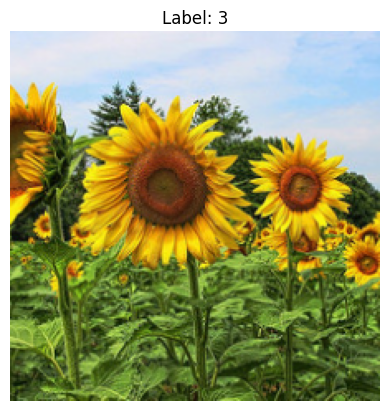

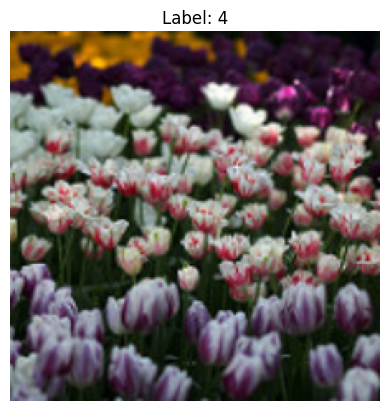

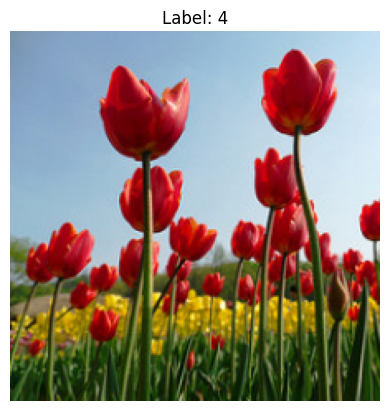

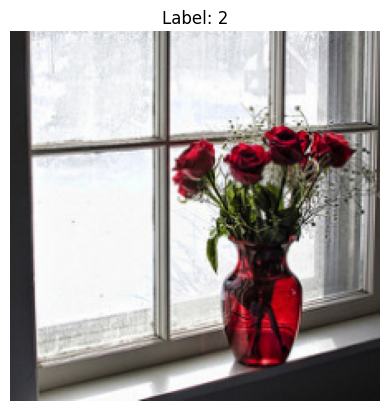

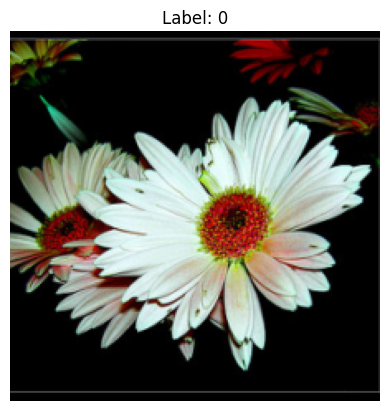

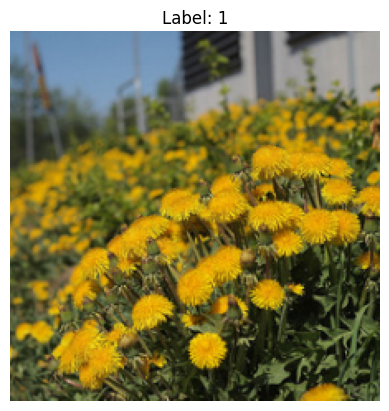

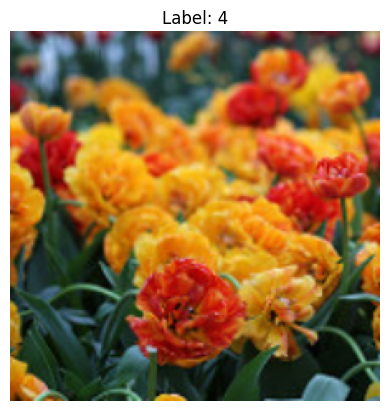

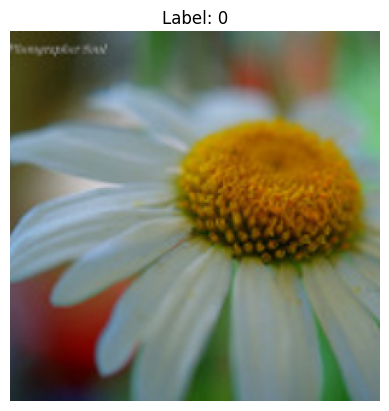

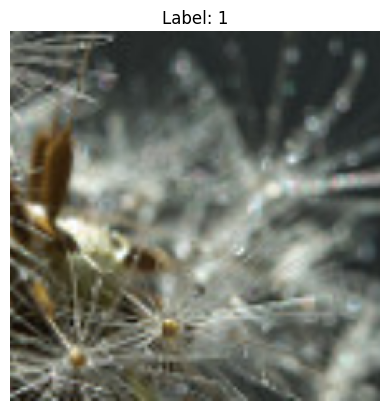

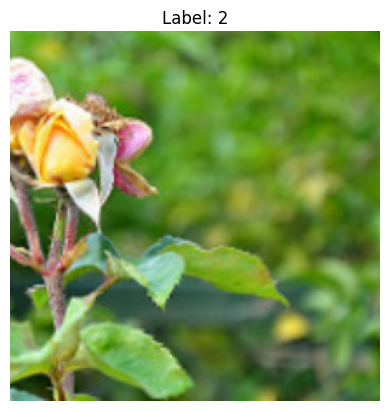

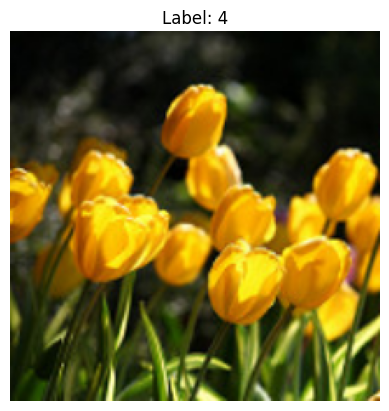

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def visualize_batch(images, labels):
    # Unnormalize the images if necessary (skip if not normalized)
    images = images.cpu()  # Move to CPU if images are on GPU
    labels = labels.cpu()

    # Create a grid of images using torchvision's make_grid
    grid_img = torchvision.utils.make_grid(images, nrow=8, padding=2)

    # Convert the grid of images from tensor to numpy for displaying
    np_img = grid_img.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(15, 15))
    plt.imshow(np_img)
    plt.title('Batch of Images with Labels')
    plt.axis('off')
    plt.show()

    for i in range(len(images)):
        img = images[i]
        label = labels[i].item()

        # Convert tensor image to numpy
        img = img.permute(1, 2, 0).numpy()

        plt.figure()
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
        plt.show()

for batch in train_dl:
    images, labels = batch
    visualize_batch(images, labels)
    break  # Stop after the first batch

In [ ]:
for batch in train_dl:
  images, labels = batch
  print(f"images.shape: {images.shape}")
  print(f"images.device: {images.device}")
  preds = model(images)
  break

images.shape: torch.Size([16, 3, 224, 224])
images.device: cuda:0


In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.610023021697998, 'val_acc': 0.17243534326553345}]

In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.4124, val_loss: 1.3111, val_acc: 0.5240
Epoch [1], train_loss: 1.1157, val_loss: 0.9300, val_acc: 0.6523
Epoch [2], train_loss: 0.9637, val_loss: 1.0077, val_acc: 0.6461
Epoch [3], train_loss: 0.8865, val_loss: 0.6007, val_acc: 0.7717
Epoch [4], train_loss: 0.8096, val_loss: 0.7612, val_acc: 0.7190


In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8916, val_loss: 0.6065, val_acc: 0.7766
Epoch [1], train_loss: 0.7311, val_loss: 0.5006, val_acc: 0.8181
Epoch [2], train_loss: 0.6945, val_loss: 0.4311, val_acc: 0.8466
Epoch [3], train_loss: 0.6320, val_loss: 0.4182, val_acc: 0.8533
Epoch [4], train_loss: 0.5894, val_loss: 0.4131, val_acc: 0.8536


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.4224, val_loss: 0.2931, val_acc: 0.8955
Epoch [1], train_loss: 0.3813, val_loss: 0.2740, val_acc: 0.9063
Epoch [2], train_loss: 0.3685, val_loss: 0.2598, val_acc: 0.9100
Epoch [3], train_loss: 0.3497, val_loss: 0.2602, val_acc: 0.9072
Epoch [4], train_loss: 0.3317, val_loss: 0.2476, val_acc: 0.9123


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.3183, val_loss: 0.2285, val_acc: 0.9209
Epoch [1], train_loss: 0.3205, val_loss: 0.2355, val_acc: 0.9239
Epoch [2], train_loss: 0.3048, val_loss: 0.2281, val_acc: 0.9202
Epoch [3], train_loss: 0.3196, val_loss: 0.2255, val_acc: 0.9225
Epoch [4], train_loss: 0.3101, val_loss: 0.2265, val_acc: 0.9218


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
history

[{'val_loss': 1.610023021697998, 'val_acc': 0.17243534326553345},
 {'val_loss': 1.311093807220459,
  'val_acc': 0.5239564776420593,
  'train_loss': 1.4123573303222656},
 {'val_loss': 0.9299858808517456,
  'val_acc': 0.652336835861206,
  'train_loss': 1.1157066822052002},
 {'val_loss': 1.0077488422393799,
  'val_acc': 0.6461272835731506,
  'train_loss': 0.9637159705162048},
 {'val_loss': 0.6006535887718201,
  'val_acc': 0.7716783881187439,
  'train_loss': 0.8864845037460327},
 {'val_loss': 0.7612118721008301,
  'val_acc': 0.7189888954162598,
  'train_loss': 0.8095682859420776},
 {'val_loss': 0.6064968109130859,
  'val_acc': 0.7766386866569519,
  'train_loss': 0.8915550708770752},
 {'val_loss': 0.5005690455436707,
  'val_acc': 0.8180849552154541,
  'train_loss': 0.7310968041419983},
 {'val_loss': 0.4310790002346039,
  'val_acc': 0.8466343283653259,
  'train_loss': 0.6945388913154602},
 {'val_loss': 0.41822198033332825,
  'val_acc': 0.8533216118812561,
  'train_loss': 0.632002592086792},


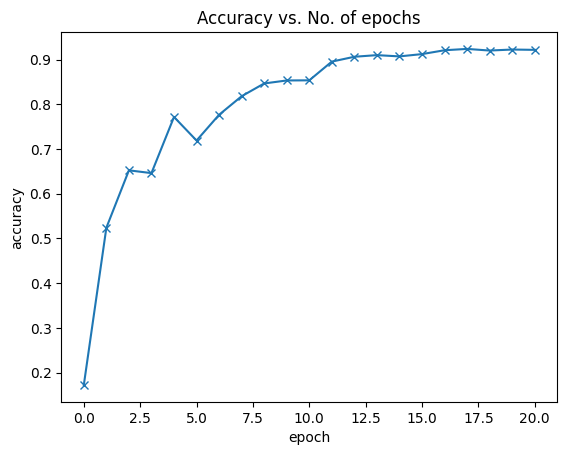

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

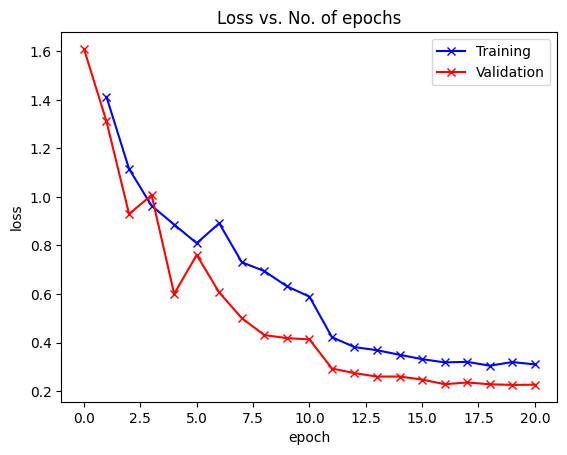

In [ ]:
plot_losses(history)

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: rose
Prediction: rose


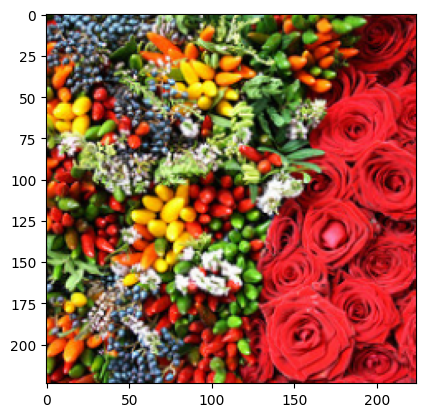

In [ ]:
show_image_prediction(*valid_ds[291])

Target: daisy
Prediction: daisy


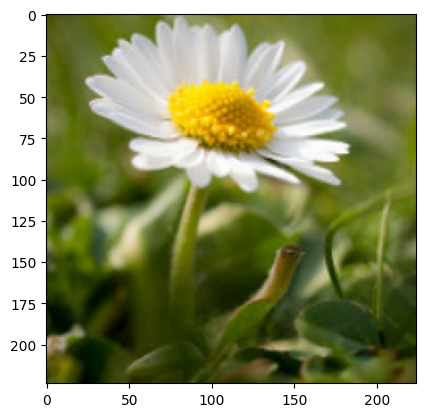

In [ ]:
show_image_prediction(*train_ds[391])

Target: daisy
Prediction: daisy


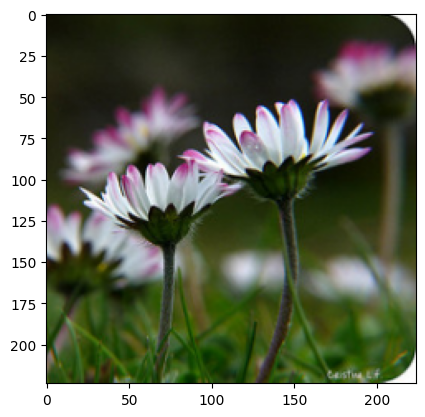

In [ ]:
show_image_prediction(*valid_ds[300])

Target: rose
Prediction: rose


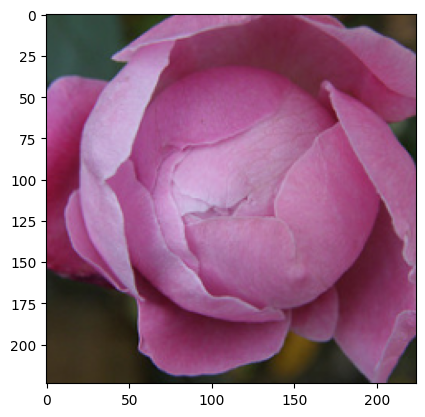

In [ ]:
show_image_prediction(*train_ds[430])

Target: rose
Prediction: tulip


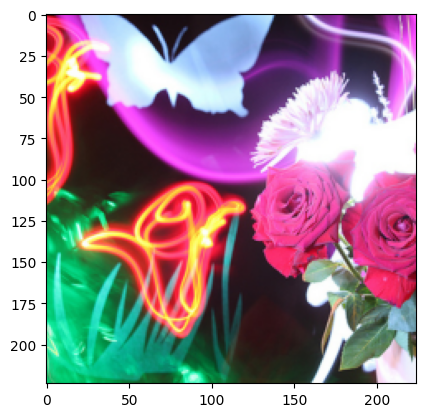

In [ ]:
show_image_prediction(*valid_ds[430])

Target: dandelion
Prediction: dandelion


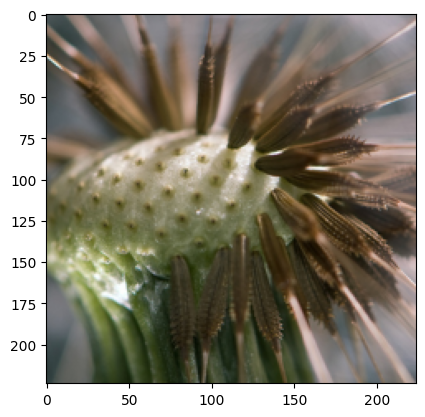

In [ ]:
show_image_prediction(*valid_ds[429])

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# Define the Covid19Model0 class
class Covid19Model0(nn.Module):
    def __init__(self):
        super(Covid19Model0, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.dropout3 = nn.Dropout(0.5)

        self.pool = nn.MaxPool2d(2, 2)

        self.linear1 = nn.Linear(128 * 31 * 31, 256)  # Adjust according to input size after pooling
        self.dropout4 = nn.Dropout(0.5)
        self.linear2 = nn.Linear(256, 128)
        self.dropout5 = nn.Dropout(0.5)
        self.linear3 = nn.Linear(128, 64)
        self.dropout6 = nn.Dropout(0.5)
        self.linear4 = nn.Linear(64, 3)  # Output layer for 3 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.dropout2(x)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.dropout3(x)
        x = self.pool(x)

        x = x.view(-1, 128 * 31 * 31)  # Flatten the output for the fully connected layers

        x = F.relu(self.linear1(x))
        x = self.dropout4(x)

        x = F.relu(self.linear2(x))
        x = self.dropout5(x)

        x = F.relu(self.linear3(x))
        x = self.dropout6(x)

        x = self.linear4(x)  # Output layer
        return x

# Define data directories
train_dir = "path_to_your_train_directory"  # Update with your actual path
test_dir = "path_to_your_test_directory"    # Update with your actual path

# Define transformations
transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_set = ImageFolder(train_dir, transform=transform)
test_set = ImageFolder(test_dir, transform=transform)

# Split training data into training and validation sets
val_pct = 0.2
val_size = int(val_pct * len(train_set))
train_size = len(train_set) - val_size
train_ds, val_ds = random_split(train_set, [train_size, val_size])

# Create DataLoaders
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False)

# Instantiate model, define loss function and optimizer
model = Covid19Model0()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Evaluation function for both training and validation datasets
def evaluate_model(model, train_loader, val_loader):
    model.eval()

    # Training accuracy
    total_correct_train = 0
    total_images_train = 0
    with torch.no_grad():
        for images, labels in train_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images_train += labels.size(0)
            total_correct_train += (predicted == labels).sum().item()
    train_accuracy = total_correct_train / total_images_train
    print(f'Training Accuracy: {train_accuracy:.4f}')

    # Validation accuracy
    total_correct_val = 0
    total_images_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images_val += labels.size(0)
            total_correct_val += (predicted == labels).sum().item()
    val_accuracy = total_correct_val / total_images_val
    print(f'Validation Accuracy: {val_accuracy:.4f}')

# Train the model
train_model(model, train_dl, criterion, optimizer, num_epochs=10)

# Evaluate the model on both training and validation datasets
evaluate_model(model, train_dl, val_dl)
